<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/docs/reproduction_paper_fig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# command line
以下のpipセクション終了後に必ず**ランタイムの再起動**を行うこと

In [1]:
!pip install scanpy scikit-misc

# install ldvae
!git clone https://github.com/kicysh/final_task_of_world_model_lecture_2021/
!pip install final_task_of_world_model_lecture_2021/package/. --use-feature=in-tree-build

     |████████████████████████████████| 2.0 MB 10.1 MB/s 
     |████████████████████████████████| 8.8 MB 23.1 MB/s 
     |████████████████████████████████| 86 kB 5.2 MB/s 
     |████████████████████████████████| 96 kB 3.7 MB/s 
     |████████████████████████████████| 11.2 MB 36.5 MB/s 
     |████████████████████████████████| 900 kB 8.7 MB/s 
     |████████████████████████████████| 1.1 MB 35.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=3eb63f0063d72790c5c67e5555b0110b69e0f0f65d1af3888513f70edcdecb5f
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=55d9abe32d54e26cec79c0d74c5a5aeeb6cae40be5f320597c1dae55a5e89291
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created 

Cloning into 'final_task_of_world_model_lecture_2021'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 182 (delta 35), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (182/182), 25.16 MiB | 4.55 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Processing ./final_task_of_world_model_lecture_2021/package
  Created wheel for LDVAE: filename=LDVAE-0.0.0-py3-none-any.whl size=3270 sha256=7c66a6f1f33690ad812c945e105b9727d40aa9c3ddd00a1784fb4c2a28ea02f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-lkubmt7e/wheels/e2/2f/44/da18d64c7ac8950bd4f266d145db33398678d80aff1a4f488f
Successfully built LDVAE


In [2]:
!mkdir data figures intermediate
!gsutil cp gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad /content/data


Copying gs://h5ad/2019-02-Pijuan-Sala-et-al-Nature/pijuan_sala_atlas.h5ad...
\ [1 files][  1.0 GiB/  1.0 GiB]   43.9 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


In [3]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
anndata                       0.8.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4   

# setting


In [1]:
# global
USE_CUDA = True

# model params
SETTING_HIDDEN_DIMS = (128,)
SETTING_LATENT_DIM = 20


SETTING_BATCH_SIZE = 1024

SETTING_N_TOP_GENES = 1000

SETTING_TRAIN_RATE = 0.8
SETTING_VAL_RATE = 0.2

DATA_PATH = '/content/data/pijuan_sala_atlas.h5ad'
W_CSV_PATH = '/content/intermediate/w.csv'
Z_CSV_PATH = '/content/intermediate/z.csv'

RANDOM_SEED = 42

In [2]:
import ldvae

import numpy as np
import pandas as pd

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import logsumexp
from torch.distributions import Normal, kl_divergence

import matplotlib.pyplot as plt

import scanpy as sc


In [19]:
# 再現性のため
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

GENERATOR = torch.Generator()
GENERATOR = GENERATOR.manual_seed(RANDOM_SEED)

# data

## read data

In [4]:
adata = sc.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 139331 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name'

## 前処理

In [5]:
idx = adata.obs.query('not doublet').index
adata = adata[idx]
sc.pp.highly_variable_genes(adata,n_top_genes=1000 ,flavor='seurat_v3',)
print(adata)


/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


AnnData object with n_obs × n_vars = 125775 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'


In [6]:
gene_index = adata.var[adata.var['highly_variable']].index
adata_df = adata.to_df()[gene_index]


## create dataset

In [7]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata: np.array, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        return data

## create dataloader

In [20]:
# dataloder
dataset = GenesDataset(adata_df.values)

n_samples = len(dataset) 
train_size = int(n_samples* SETTING_TRAIN_RATE)
val_size = int(n_samples * SETTING_VAL_RATE)
test_size = n_samples - train_size - val_size 

dataset_train ,dataset_valid, dataset_test = \
        torch.utils.data.random_split(dataset, 
                                      [train_size, val_size,test_size],
                                      generator=GENERATOR)

dataloader_all = torch.utils.data.DataLoader(
    dataset,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=False,
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    generator=GENERATOR
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    generator=GENERATOR
)


# model

## define model

In [21]:
model = ldvae.LDVAE(genes_cnt = len(adata_df.columns),
                    hidden_dims=SETTING_HIDDEN_DIMS,
                    latent_dim = SETTING_LATENT_DIM)
model.set_local_l_mean_and_var(adata_df.values)
model

LDVAE(
  (encoder_z): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_z_mean): Linear(in_features=128, out_features=20, bias=True)
  (encoder_z_var): Linear(in_features=128, out_features=20, bias=True)
  (encoder_l): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_l_mean): Linear(in_features=128, out_features=1, bias=True)
  (encoder_l_var): Linear(in_features=128, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=1000, bias=False)
    (1): BatchNorm1d(1000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
)

## train

In [22]:
n_epochs  = 100
optimizer = optim.Adam(model.parameters(), lr=7e-3)

device = 'cuda'  if USE_CUDA else 'cpu'
model.to(device)

for epoch in range(n_epochs):
    losses = []

    model.train()
    for x in dataloader_train:
        x = x.to(device)

        #model.zero_grad()
        optimizer.zero_grad()
        # forawrd and loss
        reconst, kl_l ,kl_z = model.loss(x)
        loss = torch.mean(-reconst+kl_l +kl_z)

        #nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())

    losses_val1 = []
    losses_val2 = []
    losses_val3 = []

    model.eval()
    for x in dataloader_valid:

        x = x.to(device)
        reconst, kl_l ,kl_z = model.loss(x)

        losses_val1.append(torch.mean(-reconst).cpu().detach().numpy())
        losses_val2.append(torch.mean(kl_l).cpu().detach().numpy())
        losses_val3.append(torch.mean(kl_z).cpu().detach().numpy())

    print('EPOCH: %d    Train Loss: %lf    Valid rec: %lf    Valid kl_l: %lf    Valid kl_z: %lf' %
            (epoch+1, np.average(losses),np.average(losses_val1),np.average(losses_val2),np.average(losses_val3)))


EPOCH: 1    Train Loss: 1698.130493    Valid rec: 1126.536865    Valid kl_l: 5.394742    Valid kl_z: 14.945200
EPOCH: 2    Train Loss: 801.282104    Valid rec: 883.723022    Valid kl_l: 1.872505    Valid kl_z: 14.871899
EPOCH: 3    Train Loss: 701.765320    Valid rec: 795.644714    Valid kl_l: 1.439438    Valid kl_z: 12.249546
EPOCH: 4    Train Loss: 647.962769    Valid rec: 735.180847    Valid kl_l: 1.334279    Valid kl_z: 12.503195
EPOCH: 5    Train Loss: 617.064331    Valid rec: 692.096497    Valid kl_l: 1.210363    Valid kl_z: 12.322698
EPOCH: 6    Train Loss: 595.778809    Valid rec: 655.922424    Valid kl_l: 1.325947    Valid kl_z: 12.068018
EPOCH: 7    Train Loss: 581.931763    Valid rec: 604.282837    Valid kl_l: 1.201696    Valid kl_z: 11.958024
EPOCH: 8    Train Loss: 569.700378    Valid rec: 568.396667    Valid kl_l: 1.224893    Valid kl_z: 12.235270
EPOCH: 9    Train Loss: 562.040161    Valid rec: 547.688538    Valid kl_l: 1.193757    Valid kl_z: 12.455523
EPOCH: 10    Trai

KeyboardInterrupt: ignored

# output intermediate files

## output weight

In [11]:
# w
import pandas as pd

_w = model.decoder[0].weight
bn = model.decoder[1]
sigma = torch.sqrt(bn.running_var + bn.eps)
gamma = bn.weight
b = gamma / sigma
bI = torch.diag(b)
loadings = torch.matmul(bI, _w)
loadings = loadings.detach().cpu().numpy()

W = pd.DataFrame(loadings, index=gene_index)
W.to_csv(W_CSV_PATH)


## output the latent variables (z)

In [12]:
# z
latent_array  = None
model.eval()
for x in dataloader_all:
    x = x.to(device)
    _z,_,_ = model(x)
    z_mean,_,_ = _z
    z_mean = z_mean.cpu().detach().numpy()
    if latent_array is None:
        latent_array = z_mean
    else:
        latent_array = np.concatenate([latent_array, z_mean])
pd.DataFrame(latent_array,index=adata_df.index).to_csv(Z_CSV_PATH)

# output figures

In [13]:
%pylab inline
%config InlineBackend.figure_format ='retina'

import time

import anndata
import matplotlib.colors as mcolors

import plotnine as p

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
w_df = pd.read_csv(W_CSV_PATH, index_col=0)
z_df = pd.read_csv(Z_CSV_PATH, index_col=0)

w_df = w_df.add_prefix('w')
z_df = z_df.add_prefix('z')

print('w_df====================')
print(w_df.head())
print('z_df====================')
print(z_df.head())

w_df====================
                          w0        w1        w2        w3        w4  \
index                                                                  
ENSMUSG00000025902  0.056181 -0.425652 -0.553409 -1.314907  0.289884   
ENSMUSG00000025927  0.237547 -0.956294 -0.431810  1.733929 -0.089271   
ENSMUSG00000026124 -0.344787 -1.306477  0.007086 -0.794173 -0.348210   
ENSMUSG00000026043 -0.936460 -1.920295 -1.124398  1.697590  0.368383   
ENSMUSG00000045954  0.224500 -1.828667 -0.203346  1.256315 -0.654592   

                          w5        w6        w7        w8        w9  \
index                                                                  
ENSMUSG00000025902 -0.734686 -0.519950  0.320036 -1.664365 -0.068176   
ENSMUSG00000025927  1.272876 -0.170482 -0.636896 -0.404875  1.087704   
ENSMUSG00000026124 -0.979437 -0.337790  1.120036  0.607514  0.003553   
ENSMUSG00000026043 -0.172291  0.144555  0.337097  0.358712  0.325116   
ENSMUSG00000045954 -0.041990  0.176680

In [15]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [16]:
def make_kde(x1, x2):
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f


In [17]:
# descending order by explained variance
_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]

Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)

In [18]:
metadata = adata.obs.loc[Z_df_ordered.index].join(Z_df_ordered)

print('相関係数===================================')
for ctype in np.unique(metadata['celltype']):
    z_corrs = Z_df_ordered.corrwith((metadata['celltype'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head(3)
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)

相関係数===================================
['z15: +0.25', ' z0: -0.24', 'z13: -0.21'] Allantois
['z18: -0.23', ' z4: -0.14', 'z16: -0.12'] Anterior Primitive Streak
['z19: +0.19', 'z16: -0.17', 'z18: +0.10'] Blood progenitors 1
['z19: +0.25', ' z8: +0.22', ' z1: -0.19'] Blood progenitors 2
[' z5: -0.52', ' z7: -0.19', ' z9: +0.16'] Cardiomyocytes
[' z4: +0.18', ' z6: +0.11', ' z5: -0.11'] Caudal Mesoderm
[' z4: +0.21', ' z6: +0.16', 'z19: +0.15'] Caudal epiblast
[' z3: -0.13', ' z4: +0.10', ' z8: -0.10'] Caudal neurectoderm
['z18: -0.21', 'z16: -0.15', 'z15: +0.11'] Def. endoderm
['z16: -0.32', 'z10: -0.27', 'z18: +0.16'] Endothelium
[' z0: +0.41', ' z4: -0.40', 'z17: +0.34'] Epiblast
[' z1: -0.28', ' z2: +0.23', ' z0: +0.20'] Erythroid1
[' z1: -0.19', ' z2: +0.17', ' z0: +0.16'] Erythroid2
[' z1: -0.38', ' z2: +0.29', ' z0: +0.29'] Erythroid3
[' z1: +0.61', 'z17: -0.57', ' z0: +0.23'] ExE ectoderm
[' z2: -0.73', ' z1: -0.39', 'z17: -0.38'] ExE endoderm
[' z0: -0.22', 'z13: -0.17', ' z5: 

In [19]:
from matplotlib.patches import Ellipse
from scipy import stats

vardata = W_df_ordered


In [20]:
def create_fig_0(num):
    plt.figure()
    figsize(7, 12 / 5)

    plt.subplot(1, 2, 1)

    plt.hist2d(
        Z_df_ordered[f'z'+str(num[0])], Z_df_ordered[f'z'+str(num[1])],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )

    plt.axis('equal')
    idx = np.argsort(variance_explained)[::-1]
    plt.xlabel(f'$Z_{num[0]}$ ' + f'({variance_explained[idx][num[0]]:.1%} variance)')
    plt.ylabel(f'$Z_{num[1]}$ ' + f'({variance_explained[idx][num[1]]:.1%} variance)')

    ax = plt.gca()

    color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
    cell_types = ['Erythroid3', 'ExE endoderm', 'Epiblast']
    for color, ctype in zip(color_maps, cell_types):
        X = metadata.query('celltype == @ctype')[['z'+str(num[0]), 'z'+str(num[1])]]
        xx1, xx2, f = make_kde(X['z'+str(num[0])], X['z'+str(num[1])])
        cset = ax.contour(
            xx1,
            xx2,
            f,
            levels=6,
            cmap=color,
            linewidths=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.subplot(1, 2, 2)
    plt.scatter(
        W_df_ordered['w'+str(num[0])], 
        W_df_ordered['w'+str(num[1])],
        c='lightgrey',
        rasterized=True
    )

    color_genes_set = [['r',['Hbb-bs', 'Hbb-bt', 'Hba-a2']],
                       ['g',['Pou5f1', 'Tdgf1', 'Snrpn']],
                       ['b',['Ctsh', 'Amn', 'Apoa4']]]

    for color,genes in color_genes_set:
        for gene in genes:
            x_, y_ = vardata.query('gene_name == @gene')[['w'+str(num[0]), 'w'+str(num[1])]].values[0]
            plt.arrow(0, 0, x_, y_, length_includes_head=True, color=color)
            r = 1+0.5/(x_**2+y_**2)**0.5
            plt.text(x_*r,y_*r, gene, color=color)


    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)

    plt.xlabel(f'$W_{num[0]}$')
    plt.ylabel(f'$W_{num[1]}$')

    ax = plt.gca()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig('figures/linear_pij_results_celltypes_{}_{}.pdf'.format(*num), bbox_inches='tight', dpi=400)


In [21]:
num = (0,1)
idx = (np.power(W_df_ordered['w'+str(num[0])],2)+ \
        np.power(W_df_ordered['w'+str(num[1])],2)).sort_values().index[-9:]
adata.var.loc[idx].values[::-1]


array([['Msx3', True, 159.0, 0.038974358974358976, 0.27834805041032346,
        5.8732177790564135],
       ['Hoxb5os', True, 149.0, 0.31161200556549395, 2.533639628745723,
        6.1180920496251385],
       ['Hes3', True, 228.0, 0.2455734446432121, 1.3833540558088664,
        4.3341140428634946],
       ['Hoxa1', True, 306.0, 0.4866865434307295, 2.4254572218184633,
        3.5489436879393423],
       ['Hoxaas3', True, 75.0, 1.001796859471278, 15.322591266158211,
        9.577152256289244],
       ['Bhlha9', True, 167.0, 0.013953488372093023, 0.09296445710486241,
        5.664509379192195],
       ['Hoxd4', True, 900.0, 0.08179685947127807, 0.17891196836993456,
        1.7929416449966897],
       ['Hoxb9', True, 353.0, 0.2035062611806798, 0.830879623283135,
        3.195976276610686],
       ['Klk10', True, 445.0, 0.008292585967004572, 0.027401138811172197,
        2.8397335341306635]], dtype=object)

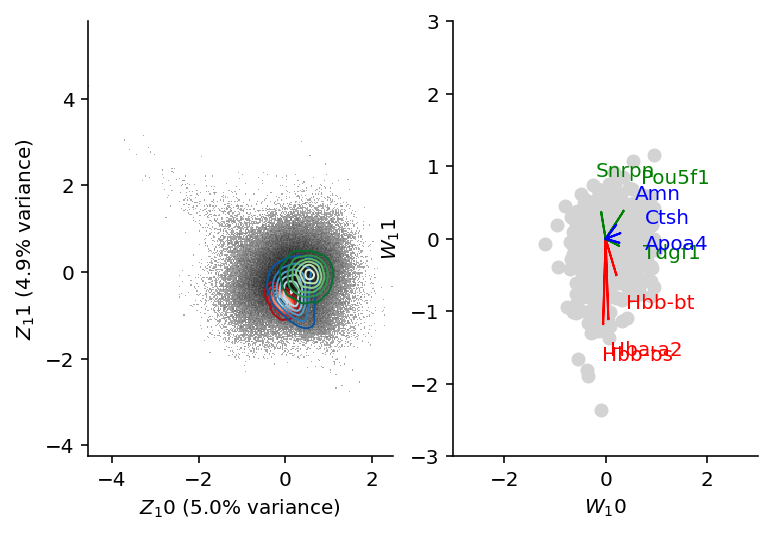

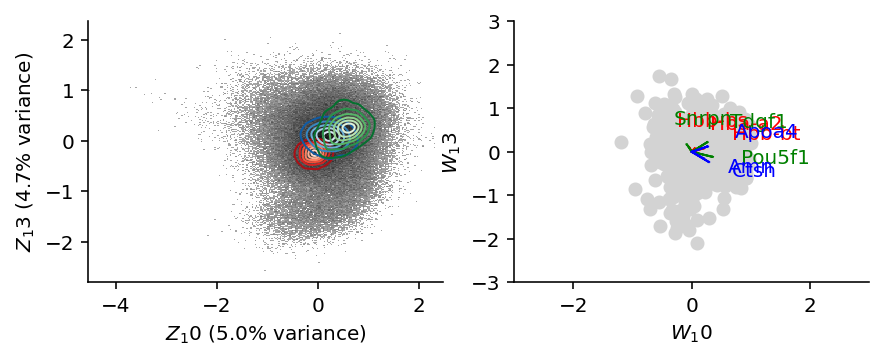

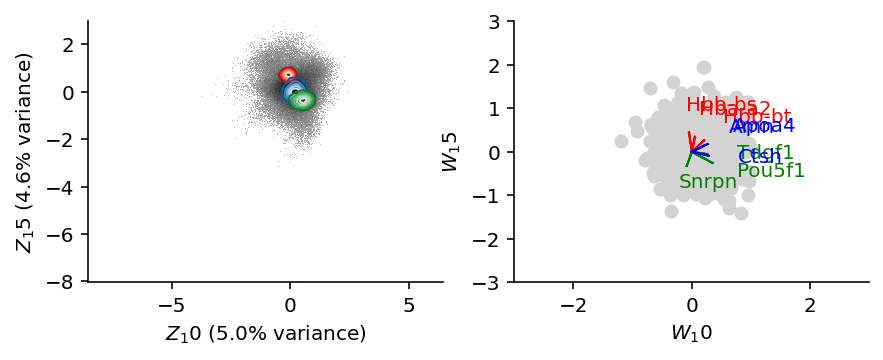

In [22]:
for i in range(10,11):
    for j in range(i+1+(i%2),17,2):
        create_fig_0((i,j))

In [ ]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/download.zip /content/figures

# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/download.zip")

['Hoxc10', 'Hoxa9', 'Hoxc9', 'Hoxc8', 'Hoxb5os', 'Hand1', 'Wnt6', 'Upk3b']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Utf1', 'Cldn4', 'Nr0b1', 'Cldn3', 'Ccl20', 'AA467197', 'Elf5', 'Rhox1']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['1700011H14Rik', 'Hes3', 'Wnt1', 'Msx3', 'Hoxb5os', 'Hoxaas3', 'Nepn', 'Pax6']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Spi1', 'Cdh5', 'Oit3', 'Icam2', 'Gm15915', 'Gpr182', 'Pf4', 'Gata2']
Categories (29411, object): ['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik', ...,
                             'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
['Hoxc8', 'H

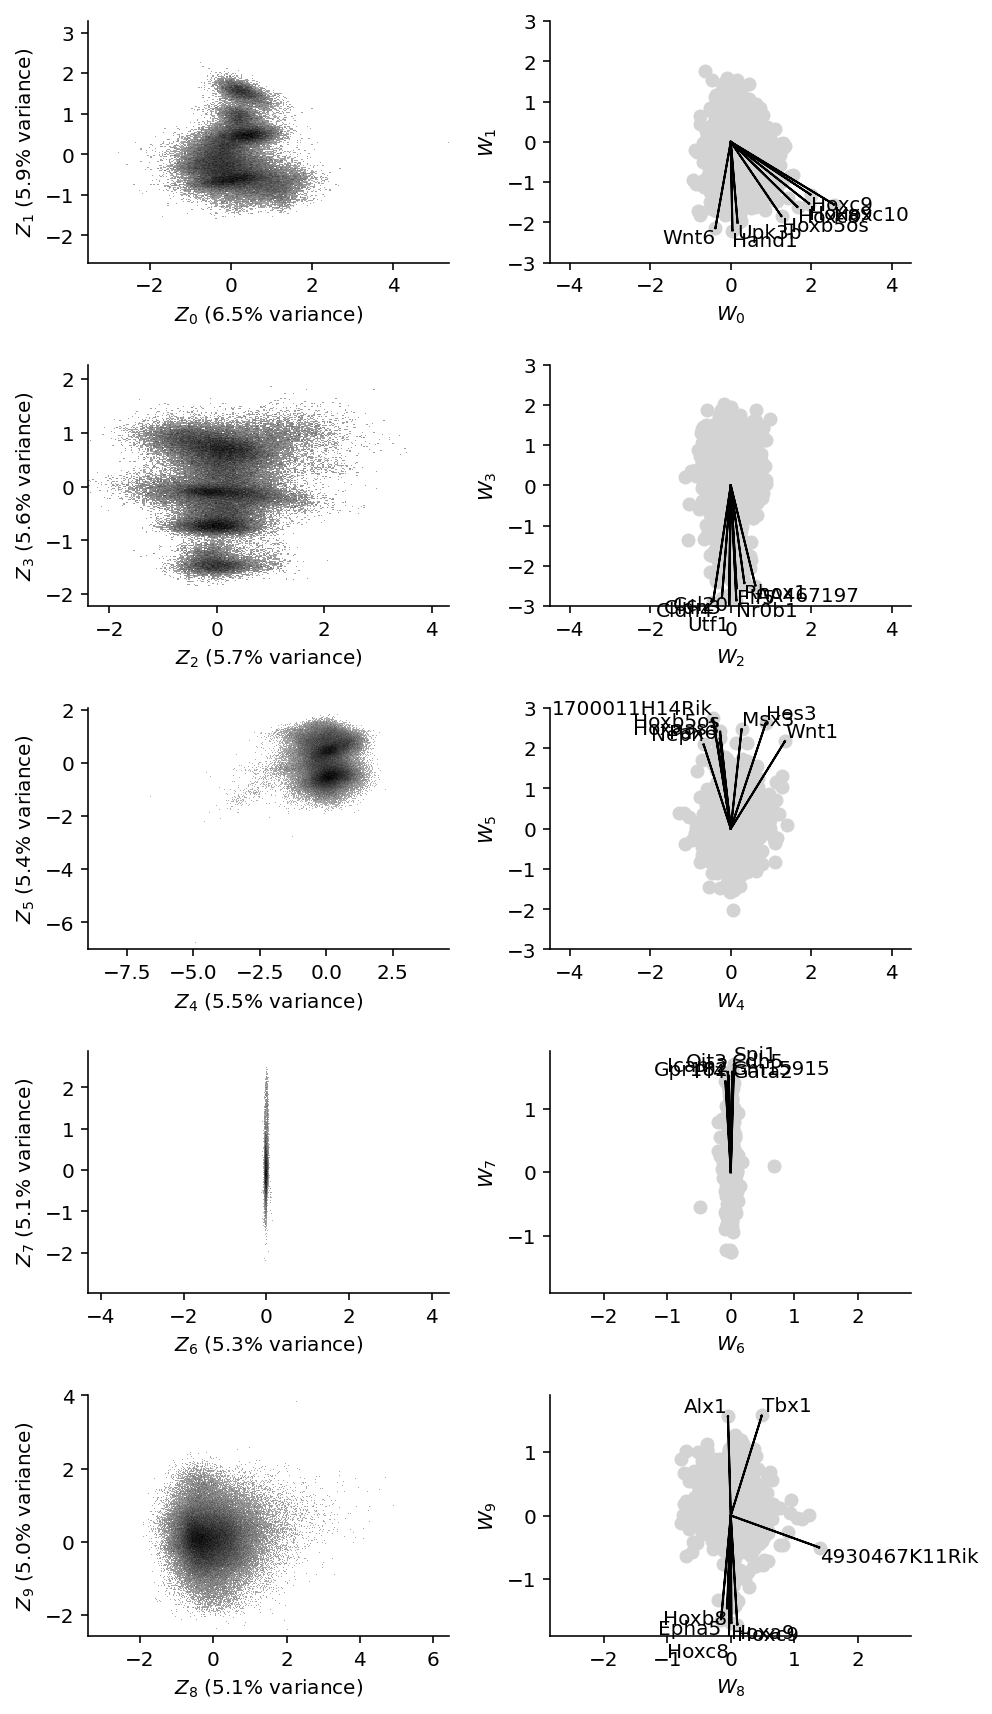

In [ ]:
figsize(7, 12)
for i in range(4):
    
    # -- Z plot --
    
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal');
    idx = np.argsort(variance_explained)[::-1]
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    
    plt.subplot(5, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right'
        if x_ > 0:
            ha = 'left'
            
        va = 'top'
        if y_ > 0:
            va = 'bottom'
            
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True))
        
        xs, ys = 0, 0
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-3, right=3)
    plt.ylim(bottom=-3, top=3)
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)